In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- 設定 ---
# 比較する条件とディレクトリパス
conditions = {
    "Na-F-OH": Path("/home/jovyan/Kaori/MD/LiB_2/structure/Al_Na_F_OH/analysis_results"),
    "Li-F-OH": Path("/home/jovyan/Kaori/MD/LiB_2/structure/Al_Li_F_OH/analysis_results"),
    "LiOH":    Path("/home/jovyan/Kaori/MD/LiB_2/structure/Al_LiOH_v8/analysis_results")
}

output_dir = Path("/home/jovyan/Kaori/MD/LiB_2/structure/Summary_Analysis")
output_dir.mkdir(parents=True, exist_ok=True)

targets = ["Al_Metal", "Al_Oxide"]
temps = [300, 400, 500, 600, 750, 900]

def collect_summary_data():
    summary_list = []
    
    for cond_name, results_path in conditions.items():
        for target in targets:
            for temp in temps:
                label = f"{target}_{temp}K"
                csv_path = results_path / f"{label}_trends.csv"
                
                if csv_path.exists():
                    df = pd.read_csv(csv_path)
                    # 最終ステップの値を代表値として取得
                    final_val = df.iloc[-1]
                    summary_list.append({
                        "Condition": cond_name,
                        "Target": target,
                        "Temp": temp,
                        "Final_MSD_Surface": final_val['MSD_Surface'],
                        "Final_H2_Count": final_val['H2_Count'],
                        "Final_Reacted_Al": final_val['Reacted_Al_Count']
                    })
    return pd.DataFrame(summary_list)

def plot_comparisons(df_summary):
    metrics = {
        "Final_MSD_Surface": ("Surface Al Diffusion (MSD, $\AA^2$)", "MSD_comparison.png"),
        "Final_H2_Count":    ("Hydrogen Generation ($H_2$ count)", "H2_comparison.png"),
        "Final_Reacted_Al":  ("Number of Reacted Al Atoms", "Reaction_comparison.png")
    }
    
    for target in targets:
        df_target = df_summary[df_summary["Target"] == target]
        
        for col, (ylabel, filename) in metrics.items():
            plt.figure(figsize=(8, 6))
            for cond in conditions.keys():
                subset = df_target[df_target["Condition"] == cond].sort_values("Temp")
                if not subset.empty:
                    plt.plot(subset["Temp"], subset[col], marker='o', label=cond, lw=2)
            
            plt.xlabel("Temperature (K)")
            plt.ylabel(ylabel)
            plt.title(f"Mechanism Comparison: {target}")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.savefig(output_dir / f"{target}_{filename}")
            plt.close()

def plot_arrhenius(df_summary):
    """拡散の活性化エネルギーを比較するためのアレニウスプロット"""
    for target in targets:
        plt.figure(figsize=(8, 6))
        for cond in conditions.keys():
            subset = df_summary[(df_summary["Target"] == target) & (df_summary["Condition"] == cond)].sort_values("Temp")
            if not subset.empty:
                # MSD/time を速度定数 k に見立てる
                # ln(MSD) vs 1/T
                inv_t = 1000 / subset["Temp"]
                ln_msd = np.log(subset["Final_MSD_Surface"] + 1e-5)
                plt.plot(inv_t, ln_msd, marker='s', label=cond)
        
        plt.xlabel("1000 / T ($K^{-1}$)")
        plt.ylabel("ln(Surface MSD)")
        plt.title(f"Arrhenius-like Plot for Al Corrosion: {target}")
        plt.legend()
        plt.grid(True)
        plt.savefig(output_dir / f"{target}_Arrhenius_plot.png")
        plt.close()

# 実行
df_all = collect_summary_data()
df_all.to_csv(output_dir / "All_Conditions_Summary.csv", index=False)
plot_comparisons(df_all)
plot_arrhenius(df_all)

print(f"統合解析が完了しました。結果は {output_dir} に保存されました。")

<>:45: SyntaxWarning: invalid escape sequence '\A'
<>:45: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_816/2826606309.py:45: SyntaxWarning: invalid escape sequence '\A'
  "Final_MSD_Surface": ("Surface Al Diffusion (MSD, $\AA^2$)", "MSD_comparison.png"),


統合解析が完了しました。結果は /home/jovyan/Kaori/MD/LiB_2/structure/Summary_Analysis に保存されました。


In [9]:
import os
import numpy as np
from ase import Atoms
from ase.io import read, write,Trajectory
from ase.build import add_adsorbate

# --- 設定項目 ---
atoms=read("/home/jovyan/Kaori/MD/LiB_2/structure/MD_Al/heat/Interface_Al_on_NMC_pristine_001_P0.000_T300K_equil.traj")
write( "/home/jovyan/Kaori/MD/LiB_2/structure/Interface_Al_on_NMC_pristine_001.xyz",atoms)
input_files = ["/home/jovyan/Kaori/MD/LiB_2/structure/Interface_Al_on_NMC_pristine_001.xyz"]
# [
#     "/home/jovyan/Kaori/MD/LiB_2/structure/Interface_Al_on_NMC_pristine_001.xyz",
#     "/home/jovyan/Kaori/MD/LiB_2/structure/Interface_AlF3_on_NMC_pristine_001.xyz",
#     "/home/jovyan/Kaori/MD/LiB_2/structure/Interface_Al2O3_on_NMC_pristine_001.xyz"
# ]

output_dir = "/home/jovyan/Kaori/MD/LiB_2/structure/with_carbon"
carbon_thickness = 10.0  # 挿入するカーボン層の厚さ (Angstrom)
carbon_density = 2.0     # アモルファスカーボンの目安密度 (g/cm3)

# フォルダの作成
os.makedirs(output_dir, exist_ok=True)

def generate_amorphous_carbon(cell_abc, thickness, density):
    """指定された面積と厚さに応じた密度のカーボン原子をランダム配置で生成"""
    area = cell_abc[0] * cell_abc[1]
    volume = area * thickness
    # 炭素の原子数計算 (密度から換算)
    mass = density * (volume * 1e-24) # g
    n_atoms = int((mass / 12.011) * 6.022e23)
    
    c_atoms = Atoms('C' * n_atoms)
    # ランダムな位置に配置
    pos = np.random.rand(n_atoms, 3)
    pos[:, 0] *= cell_abc[0]
    pos[:, 1] *= cell_abc[1]
    pos[:, 2] *= thickness
    c_atoms.set_positions(pos)
    return c_atoms

for file_path in input_files:
    if not os.path.exists(file_path):
        print(f"Skip: {file_path} は見つかりませんでした。")
        continue
        
    atoms = read(file_path)
    cell = atoms.get_cell()
    
    # 1. 基板(Al系)と正極(NMC系)の境界を特定
    # 論文の記述に基づき、下半分(低Z)をAl集電箔、上半分(高Z)をNMCと判定
    z_coords = atoms.positions[:, 2]
    z_mid = (np.max(z_coords) + np.min(z_coords)) / 2
    
    lower_idx = [i for i, p in enumerate(atoms.positions) if p[2] <= z_mid]
    upper_idx = [i for i, p in enumerate(atoms.positions) if p[2] > z_mid]
    
    substrate = atoms[lower_idx]
    nmc = atoms[upper_idx]
    
    # 2. NMC側を上方にシフトして隙間を作る
    nmc.translate([0, 0, carbon_thickness])
    
    # 3. 隙間に挿入するカーボン層を生成
    c_layer = generate_amorphous_carbon(cell.lengths(), carbon_thickness, carbon_density)
    # カーボンのZ位置を基板の直上に調整
    z_offset = np.max(substrate.positions[:, 2]) + 1.5 # 1.5Aのバッファ
    c_layer.translate([0, 0, z_offset])
    
    # 4. 全てを結合
    new_atoms = substrate + c_layer + nmc
    # セルサイズをカーボン厚み分だけ拡張
    new_cell = cell.copy()
    new_cell[2, 2] += carbon_thickness
    new_atoms.set_cell(new_cell)
    
    # 保存
    base_name = os.path.basename(file_path).replace(".xyz", "_with_C.xyz")
    out_path = os.path.join(output_dir, base_name)
    write(out_path, new_atoms)
    print(f"Generated: {out_path}")

print("\n全ての構造生成が完了し、'with_carbon' フォルダに保存されました。")

Generated: /home/jovyan/Kaori/MD/LiB_2/structure/with_carbon/Interface_Al_on_NMC_pristine_001_with_C.xyz

全ての構造生成が完了し、'with_carbon' フォルダに保存されました。


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ase.io.trajectory import Trajectory
from ase.geometry import get_distances
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# --- 全体のフォントサイズ設定 (20基準) ---
plt.rcParams.update({
    'font.size': 20, 
    'axes.labelsize': 20, 
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 16,
    'figure.titlesize': 22
})

def analyze_md_results(traj_path, output_dir, label):
    trends_csv = output_dir / f"{label}_trends.csv"
    
    # --- 新しい列 'Reacted_Al_OH_Count' をチェック対象に追加 ---
    required_cols = ['Reacted_Al_O_Count', 'Reacted_Al_F_Count', 'Reacted_Al_OH_Count', 'H2_Count']
    needs_recalc = True
    if trends_csv.exists():
        try:
            temp_df = pd.read_csv(trends_csv)
            if all(col in temp_df.columns for col in required_cols):
                needs_recalc = False
        except: pass

    if not needs_recalc:
        print(f"  -> Skip: {label} (All required data exists)")
        return trends_csv

    print(f"Analyzing: {traj_path.name} (Calculating Al-OH specifically)")
    try:
        traj = Trajectory(traj_path)
    except Exception as e:
        print(f"Error: {e}"); return None

    initial_atoms = traj[0]
    symbols = np.array(initial_atoms.get_chemical_symbols())
    indices = {s: np.where(symbols == s)[0] for s in ['Al', 'O', 'Li', 'H', 'F']}
    
    time_points, count_al_o, count_al_f, count_al_oh, h2_list = [], [], [], [], []
    dt_ps = 40.0 / max(len(traj)-1, 1)

    for i, atoms in enumerate(traj):
        time_points.append(i * dt_ps)
        
        # 1. まず「Hと結合している酸素(O_oh)」のインデックスを特定
        idx_o = indices['O'].flatten()
        idx_h = indices['H'].flatten()
        idx_o_with_h = []
        
        if len(idx_o) > 0 and len(idx_h) > 0:
            p_o = atoms.positions[idx_o]
            p_h = atoms.positions[idx_h]
            _, oh_dists = get_distances(p_o, p_h, cell=atoms.cell, pbc=atoms.pbc)
            oh_matrix = oh_dists.reshape(len(idx_o), len(idx_h))
            # Oから1.2A以内にHがいる酸素を抽出
            is_o_with_h = np.any(oh_matrix < 1.2, axis=1)
            idx_o_with_h = idx_o[is_o_with_h]

        # 2. 各種反応カウント計算用関数
        def get_reacted_count(idx_center, idx_neighbor, cutoff=2.5):
            if len(idx_center) == 0 or len(idx_neighbor) == 0: return 0
            p1, p2 = atoms.positions[idx_center], atoms.positions[idx_neighbor]
            _, d_len = get_distances(p1, p2, cell=atoms.cell, pbc=atoms.pbc)
            d_matrix = d_len.reshape(len(idx_center), len(idx_neighbor))
            return np.sum(np.any(d_matrix < cutoff, axis=1))

        # 通常のAl-O, Al-F
        count_al_o.append(get_reacted_count(indices['Al'], indices['O']))
        count_al_f.append(get_reacted_count(indices['Al'], indices['F']))
        # 特別なAl-OH (Hがついている酸素のみを相手にする)
        count_al_oh.append(get_reacted_count(indices['Al'], idx_o_with_h))

        # H2分子
        h2 = 0
        if len(idx_h) > 1:
            _, h_dists = get_distances(atoms.positions[idx_h], atoms.positions[idx_h], cell=atoms.cell, pbc=atoms.pbc)
            h2 = np.sum((h_dists > 0.01) & (h_dists < 0.85)) // 2
        h2_list.append(h2)

    # 保存
    pd.DataFrame({
        'Time_ps': time_points,
        'Reacted_Al_O_Count': count_al_o,
        'Reacted_Al_F_Count': count_al_f,
        'Reacted_Al_OH_Count': count_al_oh,
        'H2_Count': h2_list
    }).to_csv(trends_csv, index=False)

    return trends_csv

def create_summary_plots(csv_files, output_dir, target_label):
    if not csv_files: return
    data_list = []
    for temp, path in sorted(csv_files.items()):
        df = pd.read_csv(path); df['Temp'] = temp
        data_list.append(df)
    
    # 比較グラフの項目 (MSDの代わりにAl-OHを表示)
    metrics = [
        ('Reacted_Al_O_Count', 'Al bonded to O (Total)'),
        ('Reacted_Al_OH_Count', 'Al bonded to OH group'),
        ('Reacted_Al_F_Count', 'Al bonded to F'),
        ('H2_Count', 'H2 Molecule Count')
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()
    for i, (col, ylabel) in enumerate(metrics):
        ax = axes[i]
        for df in data_list:
            if col in df.columns:
                ax.plot(df['Time_ps'], df[col], label=f"{df['Temp'].iloc[0]}K", lw=3)
        ax.set_xlabel("Time (ps)"); ax.set_ylabel(ylabel)
        ax.legend(ncol=2, fontsize=12); ax.grid(True, alpha=0.3)
    
    plt.suptitle(f"Hydroxylation vs Oxidation: {target_label}", y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(output_dir / f"Summary_{target_label}_OH_Analysis.png", dpi=100)
    plt.close()

def main_analysis():
    base_dir = Path("/home/jovyan/Kaori/MD/LiB_2/structure/Al_Na_F_OH")
    analysis_dir = base_dir / "analysis_results"
    analysis_dir.mkdir(parents=True, exist_ok=True)
    
    # Al_OHも含めて解析（列名チェックにより未計算分のみ実行される）
    targets = ["Al_Oxide", "Al_Metal"] 
    temps = [300, 400, 500, 600, 750, 900]
    
    for target in targets:
        temp_csv_map = {}
        for temp in temps:
            traj_file = base_dir / f"{target}_md_{temp}K.traj"
            if traj_file.exists():
                csv_path = analyze_md_results(traj_file, analysis_dir, f"{target}_{temp}K")
                if csv_path: temp_csv_map[temp] = csv_path
        
        if temp_csv_map:
            create_summary_plots(temp_csv_map, analysis_dir, target)

if __name__ == "__main__":
    main_analysis()

  -> Skip: Al_Oxide_300K (All required data exists)
  -> Skip: Al_Oxide_400K (All required data exists)
  -> Skip: Al_Oxide_500K (All required data exists)
  -> Skip: Al_Oxide_600K (All required data exists)
  -> Skip: Al_Oxide_750K (All required data exists)
  -> Skip: Al_Oxide_900K (All required data exists)
Analyzing: Al_Metal_md_300K.traj (Calculating Al-OH specifically)
Analyzing: Al_Metal_md_400K.traj (Calculating Al-OH specifically)
Analyzing: Al_Metal_md_500K.traj (Calculating Al-OH specifically)
Analyzing: Al_Metal_md_600K.traj (Calculating Al-OH specifically)
Analyzing: Al_Metal_md_750K.traj (Calculating Al-OH specifically)
Analyzing: Al_Metal_md_900K.traj (Calculating Al-OH specifically)


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ase.io.trajectory import Trajectory
from ase.geometry import get_distances
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# --- 全体のフォントサイズ設定 ---
plt.rcParams.update({
    'font.size': 20, 
    'axes.labelsize': 20, 
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 16,
    'figure.titlesize': 22
})

def compute_manual_rdf(atoms, indices1, indices2, rmax=6.0, nbins=100):
    if len(indices1) == 0 or len(indices2) == 0:
        return np.zeros(nbins), np.linspace(0, rmax, nbins+1)
    idx1, idx2 = indices1.flatten(), indices2.flatten()
    p1, p2 = atoms.positions[idx1], atoms.positions[idx2]
    _, dists = get_distances(p1, p2, cell=atoms.cell, pbc=atoms.pbc)
    valid_dists = dists[dists > 0.01] if np.array_equal(idx1, idx2) else dists
    hist, bin_edges = np.histogram(valid_dists, range=(0, rmax), bins=nbins)
    return hist, bin_edges

def analyze_md_results(traj_path, output_dir, label):
    trends_csv = output_dir / f"{label}_trends.csv"
    trends_png = output_dir / f"{label}_reaction_trends_new.png"
    rdf_o_png = output_dir / f"{label}_rdf_Al_O.png"
    rdf_f_png = output_dir / f"{label}_rdf_Al_F.png"
    rdf_o_csv = output_dir / f"{label}_rdf_Al_O.csv"
    rdf_f_csv = output_dir / f"{label}_rdf_Al_F.csv"

    # --- チェック対象列 ---
    required_cols = ['Reacted_Al_O_Count', 'Reacted_Al_F_Count', 'Reacted_Al_OH_Count', 'H2_Count']
    
    # 全てのファイル（Al-F RDF含む）があるか確認
    needs_analysis = True
    if all(p.exists() for p in [trends_csv, trends_png, rdf_o_png, rdf_f_png]):
        try:
            df_check = pd.read_csv(trends_csv)
            if all(col in df_check.columns for col in required_cols):
                needs_analysis = False
        except: pass

    if not needs_analysis:
        print(f"  -> Skip: {label} (All files exist)")
        return trends_csv

    print(f"Analyzing: {traj_path.name}")
    try:
        traj = Trajectory(traj_path)
    except Exception as e:
        print(f"Error: {e}"); return None

    initial_atoms = traj[0]
    final_atoms = traj[-1]
    cell_vol = final_atoms.get_volume()
    symbols = np.array(initial_atoms.get_chemical_symbols())
    indices = {s: np.where(symbols == s)[0] for s in ['Al', 'O', 'Li', 'H', 'F']}
    
    # データ蓄積用
    time_points, count_al_f, count_al_oh, count_al_o, h2_list = [], [], [], [], []
    
    # RDF用 (Al-O, Al-F)
    rdf_rmax, rdf_nbins = 6.0, 100
    rdf_o_sum = np.zeros(rdf_nbins)
    rdf_f_sum = np.zeros(rdf_nbins)
    rdf_count = 0
    start_rdf_frame = int(len(traj) * 0.5)
    bin_edges = np.linspace(0, rdf_rmax, rdf_nbins + 1)
    
    dt_ps = 40.0 / max(len(traj)-1, 1)

    for i, atoms in enumerate(traj):
        time_points.append(i * dt_ps)
        
        idx_o = indices['O'].flatten()
        idx_h = indices['H'].flatten()
        idx_f = indices['F'].flatten()
        idx_al = indices['Al'].flatten()
        
        # Al-OH用酸素抽出
        idx_o_with_h = []
        if len(idx_o) > 0 and len(idx_h) > 0:
            p_o, p_h = atoms.positions[idx_o], atoms.positions[idx_h]
            _, oh_dists = get_distances(p_o, p_h, cell=atoms.cell, pbc=atoms.pbc)
            is_o_with_h = np.any(oh_dists.reshape(len(idx_o), len(idx_h)) < 1.2, axis=1)
            idx_o_with_h = idx_o[is_o_with_h]

        def get_reacted_count(idx_center, idx_neighbor, cutoff=2.5):
            if len(idx_center) == 0 or len(idx_neighbor) == 0: return 0
            _, d_len = get_distances(atoms.positions[idx_center], atoms.positions[idx_neighbor], 
                                     cell=atoms.cell, pbc=atoms.pbc)
            return np.sum(np.any(d_len.reshape(len(idx_center), len(idx_neighbor)) < cutoff, axis=1))

        count_al_o.append(get_reacted_count(idx_al, indices['O']))
        count_al_f.append(get_reacted_count(idx_al, indices['F']))
        count_al_oh.append(get_reacted_count(idx_al, idx_o_with_h))

        h2 = 0
        if len(idx_h) > 1:
            _, h_dists = get_distances(atoms.positions[idx_h], atoms.positions[idx_h], cell=atoms.cell, pbc=atoms.pbc)
            h2 = np.sum((h_dists > 0.01) & (h_dists < 0.85)) // 2
        h2_list.append(h2)

        # --- RDF積算 ---
        if i >= start_rdf_frame:
            # Al-O
            hist_o, edges = compute_manual_rdf(atoms, idx_al, idx_o, rmax=rdf_rmax, nbins=rdf_nbins)
            rdf_o_sum += hist_o
            # Al-F
            hist_f, _ = compute_manual_rdf(atoms, idx_al, idx_f, rmax=rdf_rmax, nbins=rdf_nbins)
            rdf_f_sum += hist_f
            
            rdf_count += 1
            bin_edges = edges

    # --- CSV & Figure出力 (Trends) ---
    pd.DataFrame({
        'Time_ps': time_points, 'Reacted_Al_O_Count': count_al_o,
        'Reacted_Al_F_Count': count_al_f, 'Reacted_Al_OH_Count': count_al_oh, 'H2_Count': h2_list
    }).to_csv(trends_csv, index=False)

    plt.figure(figsize=(10, 7))
    plt.plot(time_points, count_al_f, label='Al-F Count', color='blue', lw=3)
    plt.plot(time_points, count_al_oh, label='Al-OH Count', color='red', linestyle='--', lw=3)
    plt.xlabel("Time (ps)"); plt.ylabel("Number of Reacted Al"); plt.title(f"Reaction Trends: {label}")
    plt.legend(); plt.grid(True, alpha=0.3); plt.savefig(trends_png, dpi=100); plt.close()

    # --- RDF処理 ---
    if rdf_count > 0:
        r = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        dr = bin_edges[1] - bin_edges[0]
        vol_shells = 4 * np.pi * r**2 * dr
        
        # Al-O RDF
        if len(indices['O']) > 0:
            rho_o = len(indices['O']) / cell_vol
            gr_o = (rdf_o_sum / rdf_count) / (len(indices['Al']) * vol_shells * rho_o)
            pd.DataFrame({'r': r, 'g_r': gr_o}).to_csv(rdf_o_csv, index=False)
            plt.figure(figsize=(8, 6))
            plt.plot(r, gr_o, color='green', lw=2); plt.title(f"RDF Al-O: {label}")
            plt.xlabel("r (Å)"); plt.ylabel("g(r)"); plt.grid(True, alpha=0.3); plt.savefig(rdf_o_png); plt.close()

        # Al-F RDF (新規追加)
        if len(indices['F']) > 0:
            rho_f = len(indices['F']) / cell_vol
            gr_f = (rdf_f_sum / rdf_count) / (len(indices['Al']) * vol_shells * rho_f)
            pd.DataFrame({'r': r, 'g_r': gr_f}).to_csv(rdf_f_csv, index=False)
            plt.figure(figsize=(8, 6))
            plt.plot(r, gr_f, color='blue', lw=2); plt.title(f"RDF Al-F: {label}")
            plt.xlabel("r (Å)"); plt.ylabel("g(r)"); plt.grid(True, alpha=0.3); plt.savefig(rdf_f_png); plt.close()

    return trends_csv

def create_summary_plots(csv_files, output_dir, target_label):
    if not csv_files: return
    data_list = []
    for temp, path in sorted(csv_files.items()):
        df = pd.read_csv(path); df['Temp'] = temp; data_list.append(df)
    
    metrics = [
        ('Reacted_Al_O_Count', 'Al bonded to O (Total)'),
        ('Reacted_Al_OH_Count', 'Al bonded to OH group'),
        ('Reacted_Al_F_Count', 'Al bonded to F'),
        ('H2_Count', 'H2 Molecule Count')
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()
    for i, (col, ylabel) in enumerate(metrics):
        ax = axes[i]
        for df in data_list:
            if col in df.columns:
                ax.plot(df['Time_ps'], df[col], label=f"{df['Temp'].iloc[0]}K", lw=3)
        ax.set_xlabel("Time (ps)"); ax.set_ylabel(ylabel)
        ax.legend(ncol=2, fontsize=12); ax.grid(True, alpha=0.3)
    
    plt.suptitle(f"Summary: {target_label}", y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(output_dir / f"Summary_{target_label}_OH_Analysis.png", dpi=100)
    plt.close()

def main_analysis():
    base_dir = Path("/home/jovyan/Kaori/MD/LiB_2/structure/Al_Li_F_OH")
    analysis_dir = base_dir / "analysis_results"
    analysis_dir.mkdir(parents=True, exist_ok=True)
    
    targets = ["Al_Oxide", "Al_Metal"] 
    temps = [300, 400, 500, 600, 750, 900]
    
    for target in targets:
        temp_csv_map = {}
        for temp in temps:
            traj_file = base_dir / f"{target}_md_{temp}K.traj"
            if traj_file.exists():
                csv_path = analyze_md_results(traj_file, analysis_dir, f"{target}_{temp}K")
                if csv_path: temp_csv_map[temp] = csv_path
        
        if temp_csv_map:
            create_summary_plots(temp_csv_map, analysis_dir, target)

if __name__ == "__main__":
    main_analysis()

Analyzing: Al_Oxide_md_300K.traj
Analyzing: Al_Oxide_md_400K.traj
Analyzing: Al_Oxide_md_500K.traj
Analyzing: Al_Oxide_md_600K.traj
Analyzing: Al_Oxide_md_750K.traj
Analyzing: Al_Oxide_md_900K.traj
Analyzing: Al_Metal_md_300K.traj
Analyzing: Al_Metal_md_400K.traj
Analyzing: Al_Metal_md_500K.traj
Analyzing: Al_Metal_md_600K.traj
Analyzing: Al_Metal_md_750K.traj
Analyzing: Al_Metal_md_900K.traj


  -> Skip: Al_Oxide_300K (Already calculated)
  -> Skip: Al_Oxide_400K (Already calculated)
  -> Skip: Al_Oxide_500K (Already calculated)
  -> Skip: Al_Oxide_600K (Already calculated)
  -> Skip: Al_Oxide_750K (Already calculated)
  -> Skip: Al_Oxide_900K (Already calculated)


KeyError: 'MSD_Total'

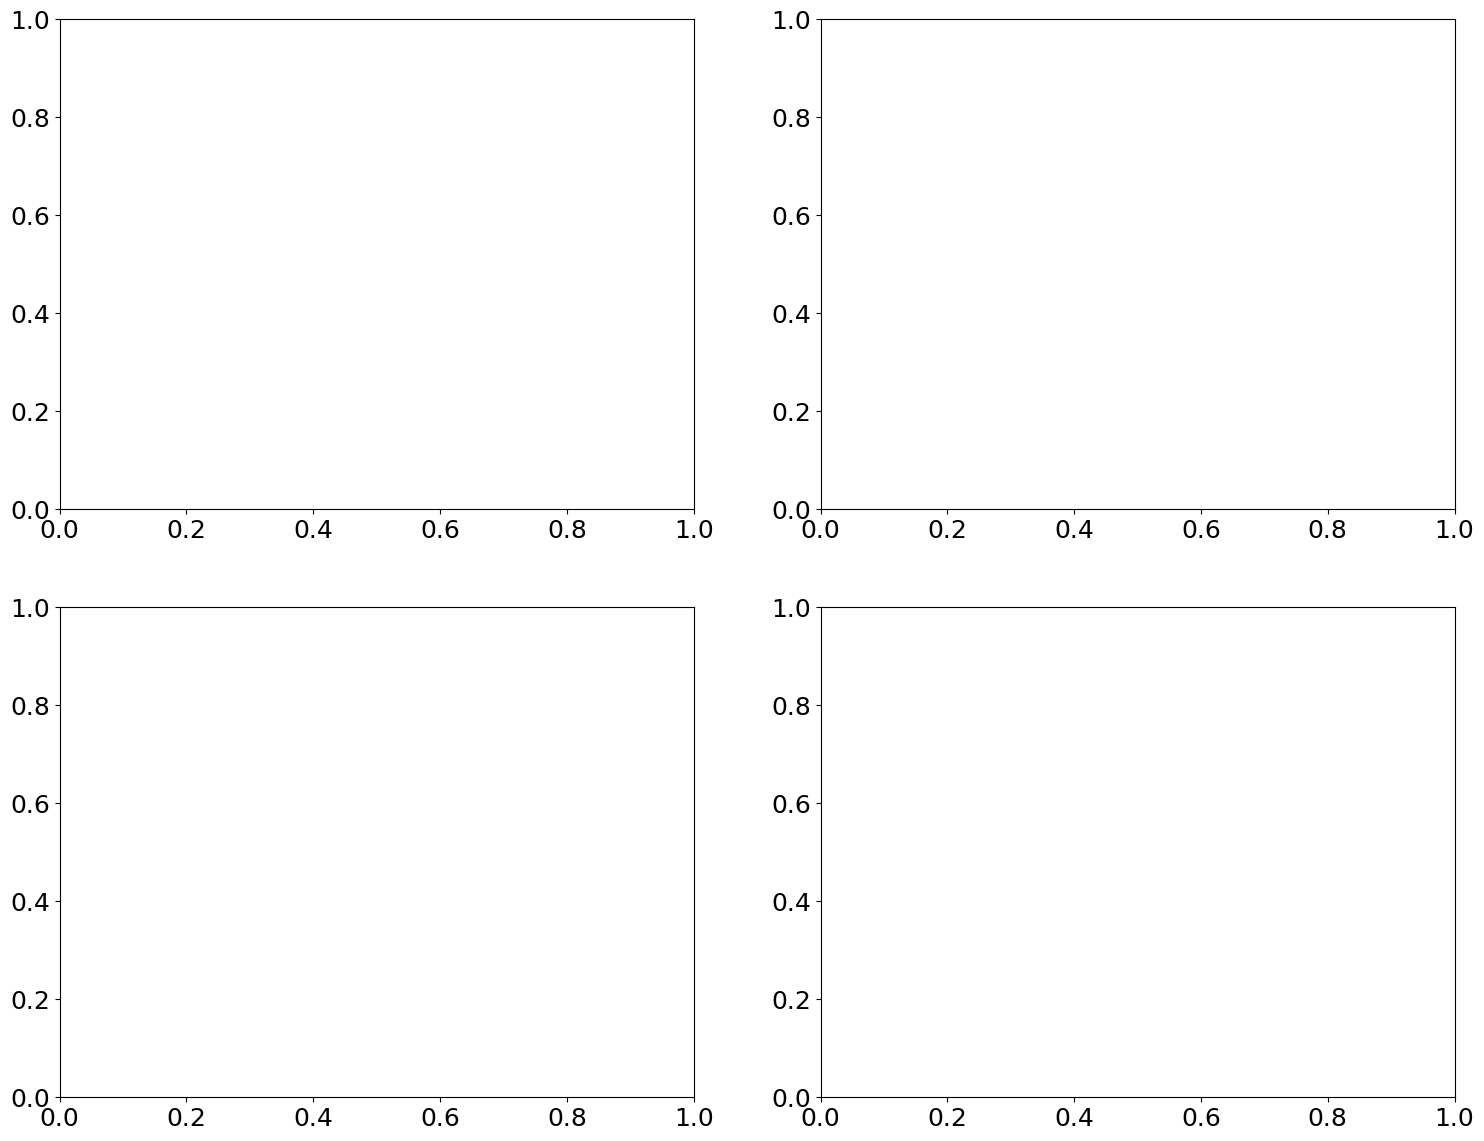

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ase.io.trajectory import Trajectory
from ase.geometry import get_distances
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# --- 全体のフォントサイズ設定 (20を基準) ---
plt.rcParams.update({
    'font.size': 20, 
    'axes.labelsize': 20, 
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 16,
    'figure.titlesize': 22
})

def analyze_md_results(traj_path, output_dir, label):
    """
    MDの結果を解析してCSVを保存する。
    すでにCSVが存在する場合は、そのパスを返すだけで解析はスキップする。
    """
    csv_path = output_dir / f"{label}_trends.csv"
    
    # --- スキップ判定 ---
    if csv_path.exists():
        print(f"  -> Skip: {label} (Already calculated)")
        return csv_path

    print(f"Analyzing: {traj_path.name}")
    try:
        traj = Trajectory(traj_path)
    except Exception as e:
        print(f"Error loading {traj_path.name}: {e}"); return None

    if len(traj) == 0: return None

    initial_atoms = traj[0]
    symbols = np.array(initial_atoms.get_chemical_symbols())
    indices = {s: np.where(symbols == s)[0] for s in ['Al', 'O', 'Li', 'H', 'F']}
    
    time_points, cn_o_avg, cn_f_avg = [], [], []
    reacted_al_o, reacted_al_f, h2_count_list, msd_total = [], [], [], []

    idx_al_total = indices['Al'].flatten()
    initial_pos_total = initial_atoms.positions[idx_al_total] if len(idx_al_total) > 0 else None

    # 時間設定 (40ps)
    total_sim_time_ps = 40.0 
    dt_ps = total_sim_time_ps / max(len(traj)-1, 1)

    for i, atoms in enumerate(traj):
        time_points.append(i * dt_ps)

        def get_cn_stats(idx_center, idx_neighbor, cutoff=2.5):
            if len(idx_center) == 0 or len(idx_neighbor) == 0: return 0, 0
            p1, p2 = atoms.positions[idx_center], atoms.positions[idx_neighbor]
            _, d_len = get_distances(p1, p2, cell=atoms.cell, pbc=atoms.pbc)
            d_matrix = d_len.reshape(len(idx_center), len(idx_neighbor))
            cn_per_atom = np.sum(d_matrix < cutoff, axis=1)
            return np.mean(cn_per_atom), np.sum(cn_per_atom >= 1)

        avg_o, count_o = get_cn_stats(indices['Al'], indices['O'])
        avg_f, count_f = get_cn_stats(indices['Al'], indices['F'])
        
        cn_o_avg.append(avg_o); reacted_al_o.append(count_o)
        cn_f_avg.append(avg_f); reacted_al_f.append(count_f)

        if initial_pos_total is not None:
            diff = atoms.positions[idx_al_total] - initial_pos_total
            msd_total.append(np.mean(np.sum(diff**2, axis=1)))
        else:
            msd_total.append(0)

        idx_h = indices['H'].flatten()
        h2 = 0
        if len(idx_h) > 1:
            _, h_dists = get_distances(atoms.positions[idx_h], atoms.positions[idx_h], cell=atoms.cell, pbc=atoms.pbc)
            h2 = np.sum((h_dists > 0.01) & (h_dists < 0.85)) // 2
        h2_count_list.append(h2)

    df_trends = pd.DataFrame({
        'Time_ps': time_points, 'CN_O_Avg': cn_o_avg, 'CN_F_Avg': cn_f_avg,
        'Reacted_Al_O': reacted_al_o, 'Reacted_Al_F': reacted_al_f,
        'H2_Count': h2_count_list, 'MSD_Total': msd_total
    })
    df_trends.to_csv(csv_path, index=False)
    return csv_path

def create_summary_plots(csv_files, output_dir, target_label):
    """
    温度ごとのデータを一つの図にまとめる (2列構成)
    """
    if not csv_files: return
    
    data_list = []
    for temp, path in sorted(csv_files.items()):
        df = pd.read_csv(path)
        df['Temp'] = temp
        data_list.append(df)
    
    metrics = [
        ('MSD_Total', 'MSD ($\AA^2$)'),
        ('CN_O_Avg', 'Avg Al-O CN'),
        ('CN_F_Avg', 'Avg Al-F CN'),
        ('H2_Count', 'H2 Count')
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()
    
    for i, (col, ylabel) in enumerate(metrics):
        ax = axes[i]
        for df in data_list:
            ax.plot(df['Time_ps'], df[col], label=f"{df['Temp'].iloc[0]}K", lw=2)
        ax.set_xlabel("Time (ps)")
        ax.set_ylabel(ylabel)
        ax.legend(ncol=2, fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.suptitle(f"Temp Comparison: {target_label}", y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(output_dir / f"Summary_{target_label}_comparison.png", dpi=100)
    plt.close()
    print(f"  -> Summary plot saved for {target_label}")

def main_analysis():
    base_dir = Path("/home/jovyan/Kaori/MD/LiB_2/structure/Al_Na_F_OH")
    analysis_dir = base_dir / "analysis_results"
    analysis_dir.mkdir(parents=True, exist_ok=True)
    
    # 解析対象のターゲットリスト (Al_OH も含めておき、関数内の exist チェックで制御)
    targets = ["Al_Oxide", "Al_Metal"] 
    temps = [300, 400, 500, 600, 750, 900]
    
    for target in targets:
        temp_csv_map = {}
        for temp in temps:
            traj_file = base_dir / f"{target}_md_{temp}K.traj"
            if traj_file.exists():
                label = f"{target}_{temp}K"
                # すでに計算済みなら CSV のパスだけ返ってくる
                csv_path = analyze_md_results(traj_file, analysis_dir, label)
                if csv_path:
                    temp_csv_map[temp] = csv_path
        
        # まとめグラフの作成
        if temp_csv_map:
            create_summary_plots(temp_csv_map, analysis_dir, target)

if __name__ == "__main__":
    main_analysis()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ase.io.trajectory import Trajectory
from ase.geometry import get_distances

# --- 設定 ---
conditions = {
    "Na-F-OH": Path("/home/jovyan/Kaori/MD/LiB_2/structure/Al_Na_F_OH"),
    "Li-F-OH": Path("/home/jovyan/Kaori/MD/LiB_2/structure/Al_Li_F_OH"),
    "LiOH":    Path("/home/jovyan/Kaori/MD/LiB_2/structure/Al_LiOH_v8")
}

output_dir = Path("/home/jovyan/Kaori/MD/LiB_2/structure/Integrated_Analysis_Report")
output_dir.mkdir(parents=True, exist_ok=True)

targets = ["Al_Metal", "Al_Oxide"]
temps = [300, 400, 500, 600, 750, 900]

# --- 関数1: RDF計算 ---
def compute_manual_rdf(atoms, indices1, indices2, rmax=6.0, nbins=100):
    if len(indices1) == 0 or len(indices2) == 0:
        return np.zeros(nbins), np.linspace(0, rmax, nbins+1)
    p1 = atoms.positions[indices1.flatten()]
    p2 = atoms.positions[indices2.flatten()]
    _, dists = get_distances(p1, p2, cell=atoms.cell, pbc=atoms.pbc)
    valid_dists = dists[dists > 0.01]
    hist, bin_edges = np.histogram(valid_dists, range=(0, rmax), bins=nbins)
    return hist, bin_edges

# --- 関数2: サマリーデータの収集とプロット ---
def run_integrated_analysis():
    summary_list = []
    
    for cond_name, base_path in conditions.items():
        analysis_path = base_path / "analysis_results"
        
        for target in targets:
            for temp in temps:
                label = f"{target}_{temp}K"
                # 1. サマリーデータの収集 (MSD, H2, 反応数)
                csv_path = analysis_path / f"{label}_trends.csv"
                if csv_path.exists():
                    df = pd.read_csv(csv_path)
                    final_val = df.iloc[-1]
                    summary_list.append({
                        "Condition": cond_name, "Target": target, "Temp": temp,
                        "Final_MSD_Surface": final_val['MSD_Surface'],
                        "Final_H2_Count": final_val['H2_Count'],
                        "Final_Reacted_Al": final_val['Reacted_Al_Count']
                    })

                # 2. RDF比較図の生成 (代表として 900K または各温度)
                traj_file = base_path / f"{target}_md_{temp}K.traj"
                if traj_file.exists() and temp == 400: # 議論の核となる900Kを抽出
                    generate_rdf_plot(traj_file, cond_name, target, temp)

    df_summary = pd.DataFrame(summary_list)
    df_summary.to_csv(output_dir / "All_Conditions_Summary.csv", index=False)
    
    # 比較グラフの生成
    plot_summary_comparisons(df_summary)
    plot_arrhenius(df_summary)

def generate_rdf_plot(traj_file, cond_name, target, temp):
    traj = Trajectory(traj_file)
    start_frame = int(len(traj) * 0.5)
    rmax, nbins = 6.0, 100
    rdf_o_sum, rdf_f_sum, count = np.zeros(nbins), np.zeros(nbins), 0
    
    for i in range(start_frame, len(traj)):
        atoms = traj[i]
        syms = np.array(atoms.get_chemical_symbols())
        idx_al, idx_o, idx_f = [np.where(syms == s)[0] for s in ['Al', 'O', 'F']]
        
        h_o, edges = compute_manual_rdf(atoms, idx_al, idx_o, rmax, nbins)
        rdf_o_sum += h_o
        if len(idx_f) > 0:
            h_f, _ = compute_manual_rdf(atoms, idx_al, idx_f, rmax, nbins)
            rdf_f_sum += h_f
        count += 1

    r = 0.5 * (edges[1:] + edges[:-1])
    dr, vol = edges[1] - edges[0], traj[-1].get_volume()
    shell_vol = 4 * np.pi * r**2 * dr
    
    plt.figure(figsize=(7, 5))
    rho_o = len(np.where(np.array(traj[-1].get_chemical_symbols()) == 'O')[0]) / vol
    plt.plot(r, (rdf_o_sum/count)/(len(np.where(np.array(traj[-1].get_chemical_symbols()) == 'Al')[0])*shell_vol*rho_o), label='Al-O (OH)', color='blue')
    
    if rdf_f_sum.sum() > 0:
        rho_f = len(np.where(np.array(traj[-1].get_chemical_symbols()) == 'F')[0]) / vol
        plt.plot(r, (rdf_f_sum/count)/(len(np.where(np.array(traj[-1].get_chemical_symbols()) == 'Al')[0])*shell_vol*rho_f), label='Al-F', color='red')
        
    plt.title(f"RDF Comparison: {cond_name} ({target}, {temp}K)"); plt.xlabel("r ($\AA$)"); plt.ylabel("g(r)"); plt.legend(); plt.grid(True)
    plt.savefig(output_dir / f"RDF_{cond_name}_{target}_{temp}K.png"); plt.close()

def plot_summary_comparisons(df_summary):
    for target in targets:
        for col, ylabel in [("Final_MSD_Surface", "Surface MSD ($\AA^2$)"), ("Final_H2_Count", "H2 Count")]:
            plt.figure(figsize=(7, 5))
            for cond in conditions.keys():
                sub = df_summary[(df_summary["Target"] == target) & (df_summary["Condition"] == cond)].sort_values("Temp")
                if not sub.empty: plt.plot(sub["Temp"], sub[col], marker='o', label=cond)
            plt.title(f"{ylabel} Comparison ({target})"); plt.xlabel("Temp (K)"); plt.ylabel(ylabel); plt.legend(); plt.grid(True)
            plt.savefig(output_dir / f"Summary_{target}_{col}.png"); plt.close()

def plot_arrhenius(df_summary):
    for target in targets:
        plt.figure(figsize=(7, 5))
        for cond in conditions.keys():
            sub = df_summary[(df_summary["Target"] == target) & (df_summary["Condition"] == cond)].sort_values("Temp")
            if not sub.empty: plt.plot(1000/sub["Temp"], np.log(sub["Final_MSD_Surface"]+1e-5), marker='s', label=cond)
        plt.title(f"Arrhenius Plot: {target}"); plt.xlabel("1000/T (K-1)"); plt.ylabel("ln(MSD)"); plt.legend(); plt.grid(True)
        plt.savefig(output_dir / f"Arrhenius_{target}.png"); plt.close()

if __name__ == "__main__":
    run_integrated_analysis()

<>:96: SyntaxWarning: invalid escape sequence '\A'
<>:101: SyntaxWarning: invalid escape sequence '\A'
<>:96: SyntaxWarning: invalid escape sequence '\A'
<>:101: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_816/3252400047.py:96: SyntaxWarning: invalid escape sequence '\A'
  plt.title(f"RDF Comparison: {cond_name} ({target}, {temp}K)"); plt.xlabel("r ($\AA$)"); plt.ylabel("g(r)"); plt.legend(); plt.grid(True)
/tmp/ipykernel_816/3252400047.py:101: SyntaxWarning: invalid escape sequence '\A'
  for col, ylabel in [("Final_MSD_Surface", "Surface MSD ($\AA^2$)"), ("Final_H2_Count", "H2 Count")]:
